In [1]:
# Imports and display settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

In [7]:
df = pd.read_csv('../data/hr_employee.csv')
print('Shape:', df.shape)
df.head()

Shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [8]:
# Basic info
df.info()
print('\nMissing values per column:\n', df.isnull().sum())
print('\nTarget value counts:\n', df['Attrition'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [10]:
# Convert target to binary
df['AttritionFlag'] = df['Attrition'].map({'Yes':1, 'No':0})


# Drop columns that leak or are IDs
cols_to_drop = ['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours', 'Attrition']
for c in cols_to_drop:
    if c in df.columns:
        df.drop(columns=c, inplace=True)


# Quick duplicate check
print('Duplicates:', df.duplicated().sum())


# Example: convert some columns to categorical dtype
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype('category')


# Show cleaned head
df.head()

Duplicates: 0


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AttritionFlag
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5,1
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7,0
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0,1
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0,0
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2,0


Overall attrition rate: 0.161


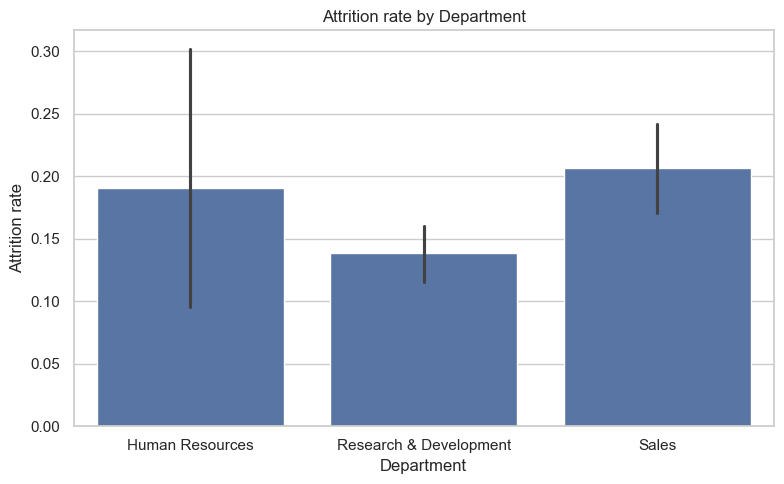

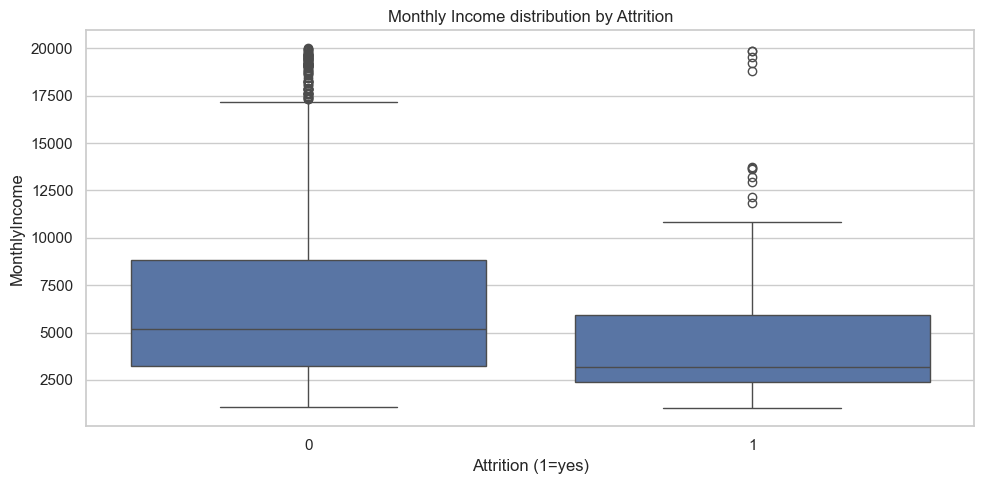

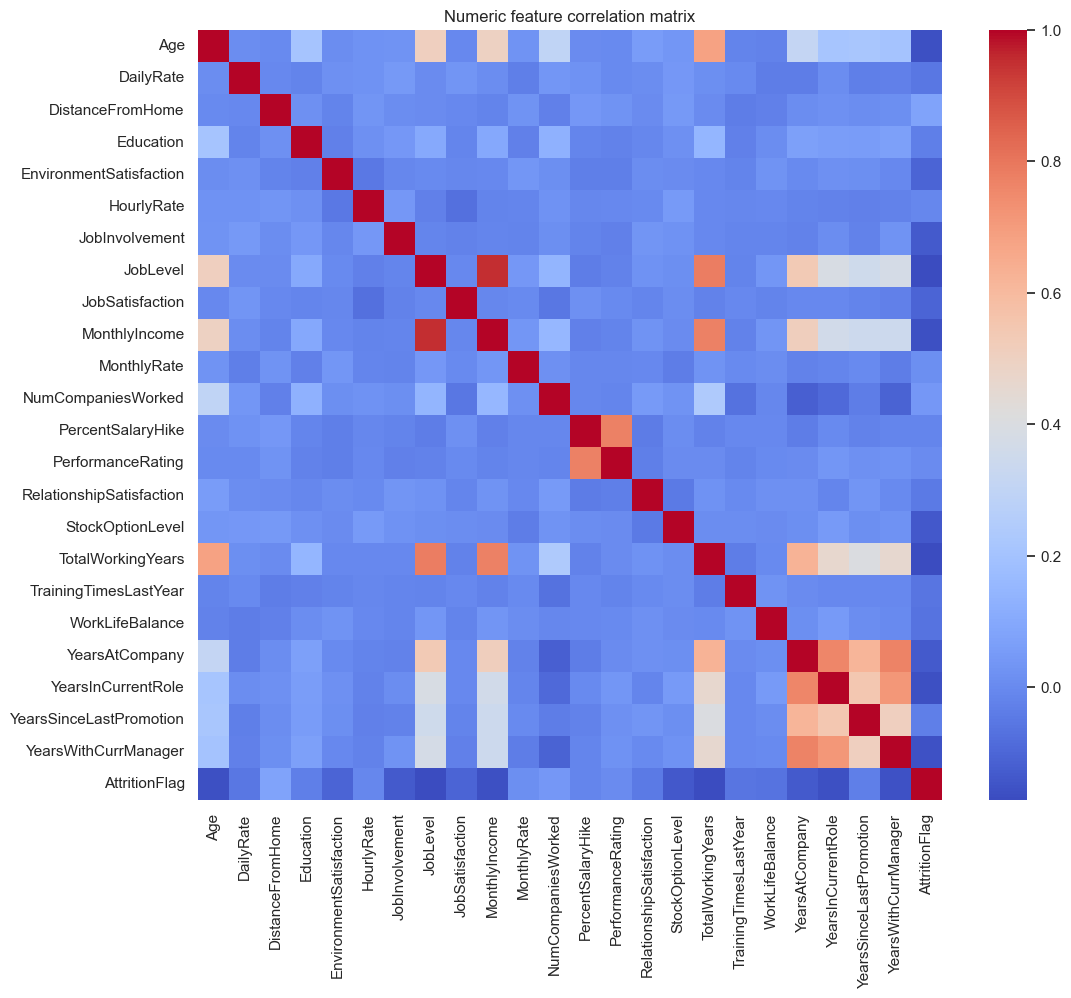

In [11]:
# Attrition rate
attr_rate = df['AttritionFlag'].mean()
print(f'Overall attrition rate: {attr_rate:.3f}')


# Attrition by Department
plt.figure(figsize=(8,5))
sns.barplot(x='Department', y='AttritionFlag', data=df)
plt.title('Attrition rate by Department')
plt.ylabel('Attrition rate')
plt.tight_layout()
plt.show()


# Distribution of MonthlyIncome by Attrition
plt.figure(figsize=(10,5))
sns.boxplot(x='AttritionFlag', y='MonthlyIncome', data=df)
plt.title('Monthly Income distribution by Attrition')
plt.xlabel('Attrition (1=yes)')
plt.tight_layout()
plt.show()


# Correlation heatmap for numeric features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12,10))
sns.heatmap(df[num_cols].corr(), annot=False, cmap='coolwarm')
plt.title('Numeric feature correlation matrix')
plt.show()

In [16]:
features = [
'Age','BusinessTravel','Department','DistanceFromHome','Education','EducationField','EnvironmentSatisfaction',
'Gender','JobLevel','JobRole','MaritalStatus','MonthlyIncome','NumCompaniesWorked','OverTime','PercentSalaryHike',
'PerformanceRating','RelationshipSatisfaction','StockOptionLevel','TotalWorkingYears','TrainingTimesLastYear',
'WorkLifeBalance','YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager'
]


# Ensure features exist
features = [f for f in features if f in df.columns]


X = df[features]
y = df['AttritionFlag']


# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = X.select_dtypes(include=['category','object']).columns.tolist()


print('Numeric features:', numeric_features)
print('Categorical features:', cat_features)


# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
transformers=[
('num', numeric_transformer, numeric_features),
('cat', categorical_transformer, cat_features)
]
)

Numeric features: ['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical features: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']


In [19]:
# Logistic Regression

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Pipeline with logistic regression
pipe_lr = Pipeline(steps=[
('preprocessor', preprocessor),
('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])


# Fit
pipe_lr.fit(X_train, y_train)


# Predict & evaluate
y_pred = pipe_lr.predict(X_test)
y_proba = pipe_lr.predict_proba(X_test)[:,1]


print('Logistic Regression classification report:')
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))

Logistic Regression classification report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.83       247
           1       0.34      0.64      0.44        47

    accuracy                           0.74       294
   macro avg       0.63      0.70      0.64       294
weighted avg       0.83      0.74      0.77       294

ROC AUC: 0.7888707037643208


In [20]:
# Decision Tree baseline

pipe_dt = Pipeline(steps=[
('preprocessor', preprocessor),
('clf', DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=5))
])


pipe_dt.fit(X_train, y_train)


y_pred_dt = pipe_dt.predict(X_test)
y_proba_dt = pipe_dt.predict_proba(X_test)[:,1]


print('Decision Tree classification report:')
print(classification_report(y_test, y_pred_dt))
print('ROC AUC:', roc_auc_score(y_test, y_proba_dt))

Decision Tree classification report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       247
           1       0.38      0.57      0.46        47

    accuracy                           0.78       294
   macro avg       0.65      0.70      0.66       294
weighted avg       0.83      0.78      0.80       294

ROC AUC: 0.6613403393918511


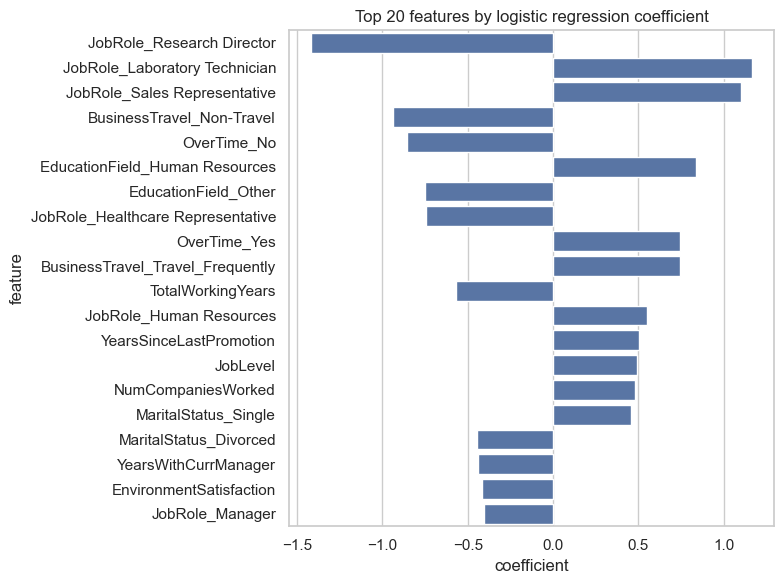

In [21]:
# Extract feature names after OneHotEncoder
ohe = pipe_lr.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_features = ohe.get_feature_names_out(cat_features)
feature_names = numeric_features + list(ohe_features)


# For Logistic Regression, coefficients
coef = pipe_lr.named_steps['clf'].coef_[0]
coef_df = pd.DataFrame({'feature':feature_names, 'coefficient':coef})
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False).head(20)


plt.figure(figsize=(8,6))
sns.barplot(x='coefficient', y='feature', data=coef_df)
plt.title('Top 20 features by logistic regression coefficient')
plt.tight_layout()
plt.show()

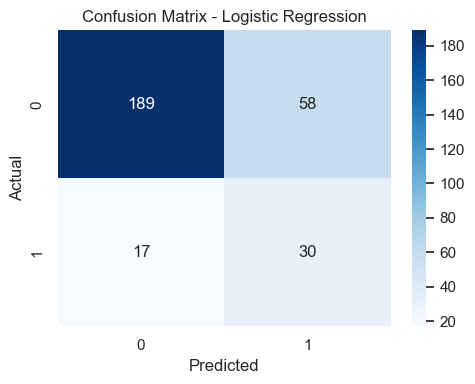

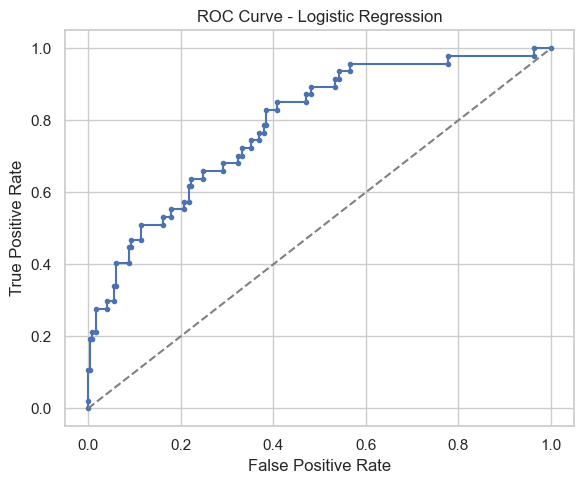

In [22]:
# Confusion matrix for logistic regression
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, marker='.')
plt.plot([0,1],[0,1],'--', color='gray')
plt.title('ROC Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()
plt.show()

# Business Interpretation & HR Recommendations

Based on model insights and feature importance analysis:

- **Focus retention strategies** on features that most strongly correlate with attrition (e.g., `OverTime`, `JobRole`, `MonthlyIncome`, `YearsAtCompany`).
- **High positive coefficients** (e.g., for `OverTime`) indicate that employees frequently working overtime are more likely to leave — improve workload management and introduce fair overtime pay policies.
- **Lower MonthlyIncome** often predicts higher attrition — consider reviewing compensation policies or offering bonuses for long-term retention.
- **Employees with short tenure or many job changes** show higher attrition risk — enhance onboarding, mentorship, and career development programs.
- **Departmental trends:** if certain departments show higher attrition, analyze internal culture, management style, or workload differences.
- **Create targeted engagement programs** (surveys, workshops, and reward systems) for high-risk employee segments.
- **Establish continuous HR analytics dashboards** to monitor real-time turnover trends and proactively address potential issues.